#CO70058 Computer Vision
#Tutorial 4 - Image Sequence Processing

References:
*   `Learning OpenCV 3` book
*    Udacity course, `Introduction to Computer Vision`
*    Udacity course, `Computational Photography`

YouTube:
*    [Harris Corner Detection + coding it in Matlab](https://www.youtube.com/watch?v=eUKw6hF7asw)

## Some theory first:

### Why do we want to detect corners?

Corners are basic features that can be detected in an image. They were created to represent objects in the image in an invariant form that will be the same, or at least very similar, in other similar images of
the same scene or object.

In the literature, this idea has evolved from corners to keypoints. You will be hearing a lot about **keypoints** and **descriptors** in the next classes. Keypoints encode information about a small region in the image such that the keypoint is highly recognizable and, at least in principle, largely unique. The descriptors basically describe each keypoint using less memory. So, the descriptors are like a summary about the keypoints information. The decriptors are used to mach keypoints in different images, so that you know where the objects or the camera moved between frames.

From the OpenCV book:

> From an intuitive point of view, you can think of a keypoint like a piece from a jigsaw puzzle. When you begin the puzzle, some pieces are easily recognized: the handle of a door, a face, the steeple of a church. When you go to assemble the puzzle, you can immediately relate these keypoints to the image on the puzzle box and know immediately where to place them. In addition, if you and a friend had two unassembled puzzles and you wanted to know if they were, for example, both different images of the beautiful Neuschwanstein Castle, you could assemble both puzzles and compare, but you could also just pick out the most salient pieces from each puzzle and compare them. In this latter case, it would take only a few matches before you were convinced that they were either literally the same puzzle, or two puzzles made from two different images of the same castle.


The earliest ancestor of the modern keypoint is the Harris corner, which is what we will be implementing in this tutorial. Harris corners are invariant to rotation but not to scale. Other more robust feature detector like SIFT are also scale invariant.

### What is a corner?

A corner is a region in the image where the gradient has two or more dominant directions. What does this mean?

Look at the image below and imagine a square window shifting through the image. If we had no dominant direction (gradients would be zero) then we would be on a "flat" region of the image. If we had one dominant direction we would be on an "edge". If we have more than one dominant direction we have a "corner". Intuitively, corners—not edges—are the points that
contain enough information to be picked out from one frame to the next.


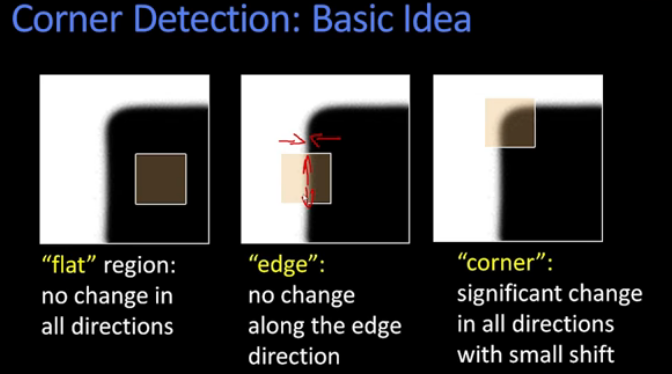

It is very important to understan that in a corner, when we shift the window (the yellow square) around, the image inside it will change! This is the main observation that has led to the developement Harris corner detector.

An example where you have multiple corners is in the camera calibrating patterns:


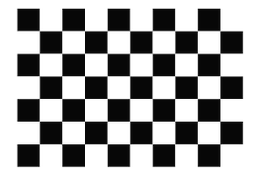

### What is the mathematical definition of a Harris Corner?

As aforementioned, a corner is a point where no matter how we shift an imaginary window the image/intensity changes. Therefore, the Harris corner detector is based on the following equation:

\begin{equation}
E(u, v) = \sum_{x, y} w(x, y) [I(x + u, y + v) - I(x, y)]^{2}
\end{equation}

, where $I(x, y)$ is the intensity at the pixel with coordinates $(x, y)$. In practice, we will use a simplified version of this formula, which I will explain later on. $E$ you can think about it as an energy function, the higher the value the more likely you have a corner in that window.

#### What is going on in this equation?

Look at this figure:

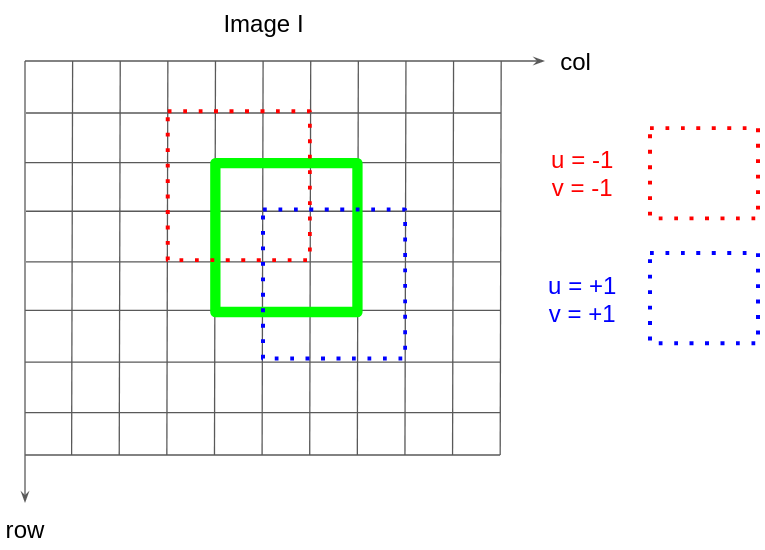

Imagine that you have a picture ($I$). Let's consider the green window of that image, centered around a point ($x = a, y = b$). What we calculate with this formula is how different the image inside the green window is different from the image inside the `red window` (corresponding to a shift of $u = -1$, $v = -1$), and the `blue window` ($u = 1$, $v = 1$), and the other windows (with other shift $u$ and $v$ values). So $u$ and $v$ are shift values to our window. Notice that when both $u$ and $v$ are $0$, we get basically comparing the same region of the image so $E(0, 0) = 0$.

In other words, we can think of $u = \Delta x$ and $v = \Delta y$. And remeber, $u$ and $v$ are small shifts, since we want the corner to be associated to a specific position.

#### What is $w(x, y)$?

It's called the window function. This function gives a weight to each pixel inside our green window. For example, when we use a called `squared-window` (like the one we show on the previous figure), all the pixels inside the green region have a weight of `1.0` and the outside pixels have a weight of `0.0`. We can also, for example, use a `gaussian-window` which gives a larger weight to the pixels closer to the centre of the green region and a smaller weight to the pixels away from the centre.

Technically speaking, when we use a `squared-window` the computation is faster, but with a `gaussian-window` we get smoother and better results.

#### What happens when a picture is very smooth?

If the picture is very smooth then when we compare the green window with the red, blue or any other shifted windows, they will practically look the same. So E(u, v) will be practically zero.

The opposite would happen if we had an image with many corners. Thre, we would have many points with high energy values.

### Simpler formula

Since this algorithm is from a time when computers were very slow, they had to find a way to simplify the previous equation to make it more efficient. They found out that the previous formula can be simplified to the following (this can be derived using a second order Taylor expansion of the previous formula, but I will skip that part):

\begin{equation}
  E(u, v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}
\end{equation}
, where
\begin{equation}
  M = \sum_{x, y} w(x, y)
  \begin{bmatrix}
    I_x I_x & I_x I_y\\
    I_y I_x & I_y I_y
  \end{bmatrix}
\end{equation}

Here, $Ix$ and $Iy$ are image derivatives in $x$ and $y$ directions respectively. (These can be easily found using [cv2.Sobel()](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d), like we did in [Tutorial 1](https://colab.research.google.com/drive/1iZxP8hvPbRyTGnDSUCxe6uXHPihyyOCv)). To apply a gaussian window function $w(x, y)$ we could simply apply a [cv2.GaussianBlur()](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1) to the $I_{xx}, I_{xy}$ and $I_{yy}$ values. If we expand that equation we get:

\begin{equation}
  E(u, v) \approx \sum_{x, y} w(x, y) (u^2 I_x^2 + 2 u v I_x I_y + v^2 I_y^2)
\end{equation}

The function $E(u, v)$ is locally approximated by a quadratic form, as we can see from the curved 3d image below. The higher we are on that surface, the higher the energy. If we consider a slice of that surface $(u^2 I_x^2 + 2 u v I_x I_y + v^2 I_y^2) = const.$ we get an ellipse, and that ellipse is enough to tell us whether or not we have a corner!

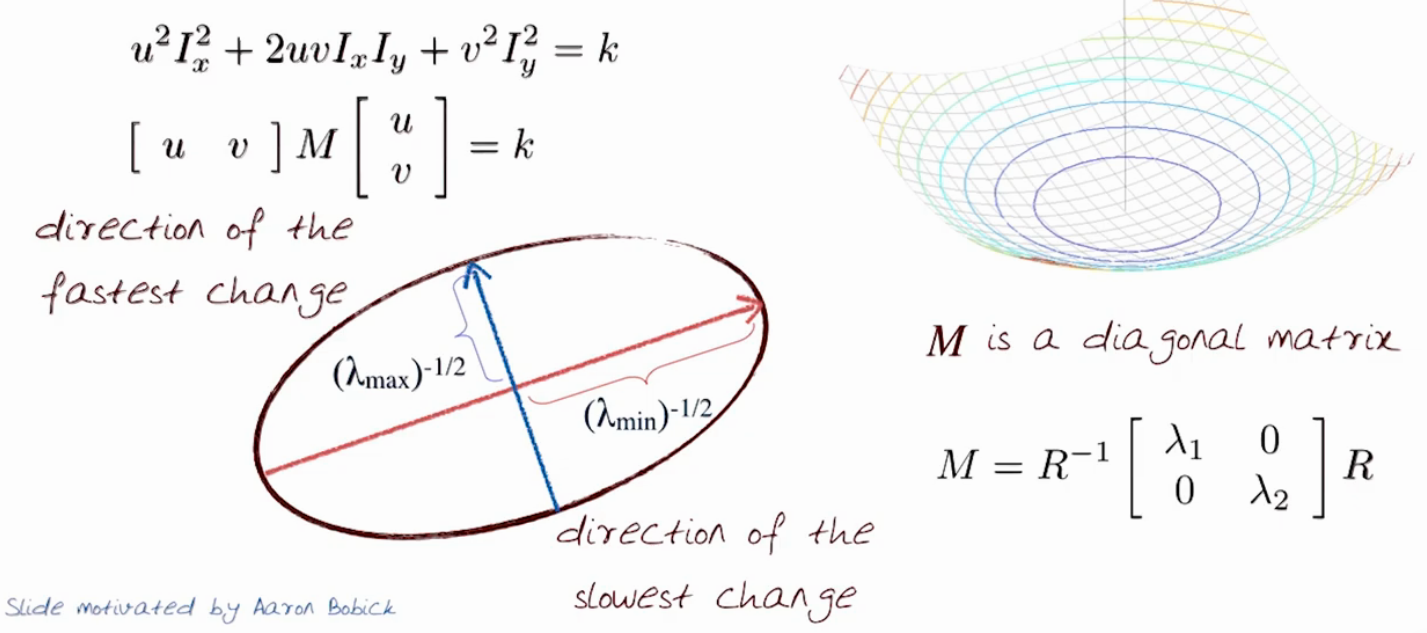

I know this looks quite scary but just read a bit more and I think you will get the idea!

Then, they found out that the shape of the ellipse can be represented by the eigenvalues of matrix $M$. Where, the largest eigenvalue will give us the direction of the quickest change (smallest part of the ellipse), and the lowest eigenvalue give us the direction of the slowest change (larger part of the ellipse). They found out that looking at the eigenvalues is enough to know wether or not we have a corner. Well think about it, if we have small eigenvalues it means that the ellipse is small, so we need to be on the bottom of the surface (where the energy is small). On the other hand, if both of them are very large, then we have a big ellipse that will only fit in the surface in a high energy, so it is very likely to be a corner.

#### But what about if one of the eigenvalues is very large and the other one very small?

Imagine a simple case of a vertical edge, there $I_y = 0$, the gradient in the $y$ direction is zero so $M$ becomes:

\begin{equation}
M = \sum_{x, y} w(x, y)
  \begin{bmatrix}
    I_x I_x & 0\\
    0 & 0
  \end{bmatrix}
\end{equation}

and the smallest eigenvalue becomes zero, so the longest part of the ellipse becomes infinitely long since we have an edge! So this means that with this window we can only determine the position of the window in one direction (the $x$ coordinate), so it is not a corner. So we can use the eigenvalues of $M$ to see the "cornerness" of a window. The corner is as strong as the minimum eigenvalue of matrix $M$.

So the "cornerness" can be evaluated using the following equation (which replaces the previous ones):
\begin{equation}
R = det(M) - \alpha(trace(M))^{2} = \lambda_1 \lambda_2 - \alpha (\lambda_1  + \lambda_2)^2
\end{equation} 

, where $\alpha$ is a constant between $0.04$ and $0.06$ (defined in their paper), so $R$ depends only on the eigenvalues of $M$!

Now, the beautiful thing is that they found out that we do not need to explicitly calculate the eigen values since we can get the determinant and trace from the gradients directly. So all of the Harris Corners theory, results in the following equation, which is what we will be calculating:

\begin{equation}
R = det(M) - \alpha(trace(M))^{2}
\end{equation}

\begin{equation}
det(M) = (I_x I_x) (I_y I_y) - (I_x I_y) (I_y I_x)
\end{equation}
\begin{equation}
trace(M) = (I_x I_x) + (I_y I_y)
\end{equation}

$R > 0$ we have a corner. $R < 0$ we have an edge (which happens when $\lambda_1 >> \lambda_2$ or vice versa). If $|R|$ is small, then we have a "flat" region

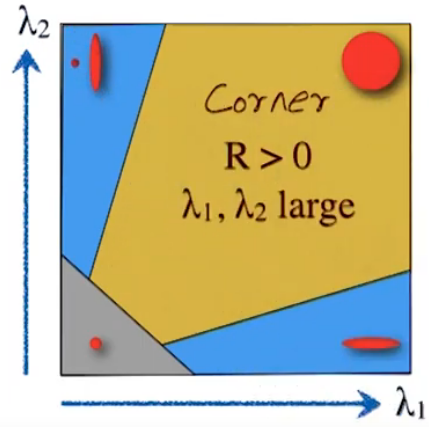

So we first apply that equation ($R = det(M) - \alpha(trace(M))^2$), whithout explicitly computing the eigenvalues. Then we apply a threshold to get only candidate corners ($R > threshold$). Finally, we apply non-maximum supression to void having multiple corners on the same window of the image.

## Code

Now let's do this in code. Here I will start by creating a simple binary image.

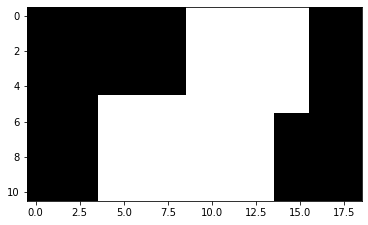

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


im = np.array([[0, 0, 0, 0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255
               , 255, 255, 255,   0,   0, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 0, 0, 0],
               [0, 0, 0, 0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0, 0, 0, 0]], dtype=np.uint8)
height, width = im.shape

plt.imshow(im, cmap='gray', vmin=0, vmax=255)
plt.show()

Now we can compute the image gradients. Notice that we do a gaussianblur to the gradients (this corresponds to applying a gaussian window $w(x, y)$, if you wanted to use the squared window you do not need to blur).

Here I will also plot the images of the gradients so that you can see which pixels "activated" more each of the gradients.

I_xx


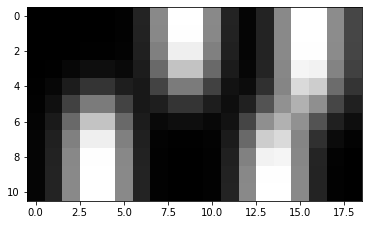

I_xy = I_yx


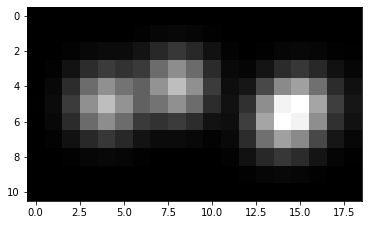

I_yy


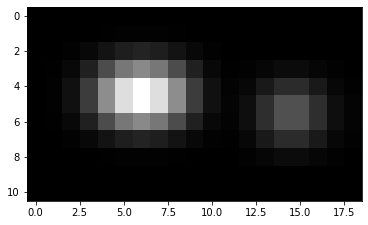

In [9]:
#Gaussian blur: 
#Sobel for input grayscale images
#NOTE: 1st compute I_x and I_y gradients
kernel_size = 5
I_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=kernel_size)
I_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=kernel_size)
I_x = np.absolute(I_x)
I_y = np.absolute(I_y)

I_xx = np.square(I_x) # = np.multiply(I_x, I_x)
#print(np.array_equal(np.square(I_x), np.multiply(I_x, I_x)))
I_xy = np.multiply(I_x, I_y)
I_yx = I_xy.copy() # = np.multiply(I_y, I_x)#
I_yy = np.square(I_y) # = np.multiply(I_y, I_y)
#Similar to applying low pass filter to eliminate high frequency information
#arguments: input image, output image, kernel size, kernel std along x, kernel std along y
I_xx = cv2.GaussianBlur(I_xx, (kernel_size, kernel_size), 0)
I_yx = cv2.GaussianBlur(I_yx, (kernel_size, kernel_size), 0)
I_yy = cv2.GaussianBlur(I_yy, (kernel_size, kernel_size), 0)

print("I_xx")
plt.imshow(I_xx, cmap='gray')
plt.show()
print("I_xy = I_yx")
plt.imshow(I_yx, cmap='gray')
plt.show()
print("I_yy")
plt.imshow(I_yy, cmap='gray')
plt.show()

Now, let's use the Harris Corner equation:

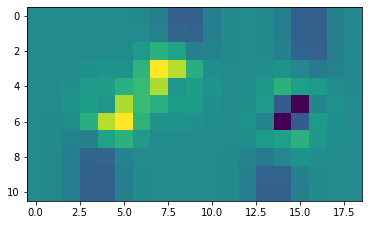

In [18]:
alpha = 0.04
detM = np.multiply(I_xx, I_yy) - np.multiply(I_xy, I_yx)
traceM = I_xx + I_yy
R = detM - alpha * np.square(traceM)

plt.imshow(R)
plt.show()
#the higher the R value the more likely it is to be a corner

Now, from the values of R we can tell whether or not we have a corner.

What is going on here? I wanted to avoid having multiple corners around the same region of the image so I created a mask (`im_corners_mask`) which I will be using to see if that area of the image was already used or not.

Another thing is that I do not want to have corners detected in the border of the image since the response depends a lot in the way we define the border.

Basically, I first sort the R values from higher to lower (from most likely to be a corner to less likely). Then, I iterate through the R values. If the point associate to that R is not close to the border I will save that corner. I will also draw a circle around that point in the mask to forbid other corners to be detected inside that circle. Once the R values are not high enough, smaller than a threshold we break the loop.

(array([ 6,  5,  6,  5, 10,  0,  0,  0,  0,  9, 10, 10,  1,  1,  9, 10,  9,
        2,  1,  8,  2,  9,  1,  8,  8,  3,  0,  1,  2,  9,  9, 10,  1, 10,
        0, 10, 10,  0,  0,  9,  8,  1,  7,  2,  9,  2,  1,  8,  3,  8,  7,
        2,  5,  6,  8,  3,  0,  1,  2,  3,  0, 10, 10, 10,  0, 10,  9,  0,
        1,  9,  1,  9,  8,  7,  2,  9,  8,  2,  4,  6,  0,  9, 10,  1,  8,
        7,  6,  2, 10, 10, 10,  0,  9,  9,  9,  9, 10, 10,  0, 10,  0,  0,
        0,  0,  1,  1,  2,  9,  1,  1,  8,  3,  1,  8,  5,  9,  2,  4,  8,
        8,  7,  3,  2,  3,  1,  8,  7,  8,  7,  3,  2,  4,  7,  5,  7,  2,
        1,  8,  4,  6,  6,  5,  3,  6,  2,  7,  7,  5,  4,  3,  8,  4,  7,
        6,  3,  6,  3,  4,  6,  5,  5,  6,  3,  3,  8,  6,  5,  5,  6,  3,
        4,  4,  5,  7,  4,  2,  7,  6,  5,  7,  4,  5,  4,  5,  5,  4,  4,
        7,  4,  7,  2,  3,  6,  4,  5,  4,  7,  2,  7,  3,  6,  4,  5,  4,
        5,  3,  6,  6,  3], dtype=int64), array([14, 15, 15, 14,  4, 15,  9,  8, 16,  3, 13, 14, 16

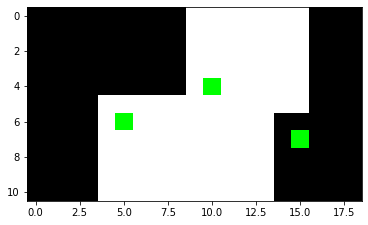

In [20]:
im_corners_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_corners_mask = np.zeros_like(im) # Where I will avoid having multiple corners in the same region / same shape and size as im

# Indices of the sorted elements of a N-dimensional array (R)
#Sort R values from higher to lower
ind = np.unravel_index(np.argsort(R, axis=None), R.shape)
print(ind)
was_r_max_found = False
threshold = -1
border_size = kernel_size - 1 # to avoid detecting corners in the border of the image
min_distance_between_corners = kernel_size
for ind_y, ind_x in zip(ind[0][::-1], ind[1][::-1]): # [::-1] get R values from higher to lower
    tmp_R = R[ind_y, ind_x]
    if ind_y < border_size or ind_y > height - border_size:
        continue
    if ind_x < border_size or ind_x > width - border_size:
        continue
    if not was_r_max_found:
        R_max = tmp_R
        threshold = 0.01 * R_max
        im_corners_rgb[ind_y, ind_x] = [0, 255, 0]
        cv2.circle(im_corners_mask, (ind_x, ind_y), radius=min_distance_between_corners, color=255, thickness=-1)
        was_r_max_found = True
        continue
    if tmp_R < threshold:
        break
    # check first if point not masked already
    if im_corners_mask[ind_y, ind_x] != 255:
        im_corners_rgb[ind_y, ind_x] = [0, 255, 0]
        cv2.circle(im_corners_mask, (ind_x, ind_y), radius=min_distance_between_corners, color=255, thickness=-1)

plt.imshow(im_corners_rgb)
plt.show()

The detected corners are shown in green.

Note: The rest of the tutorial questions I had no time to create code for them. If any of you wants to volunteer feel free to send me the code and I will upload it here.

# Q2. Corner detection with ORB

(-0.5, 849.5, 679.5, -0.5)

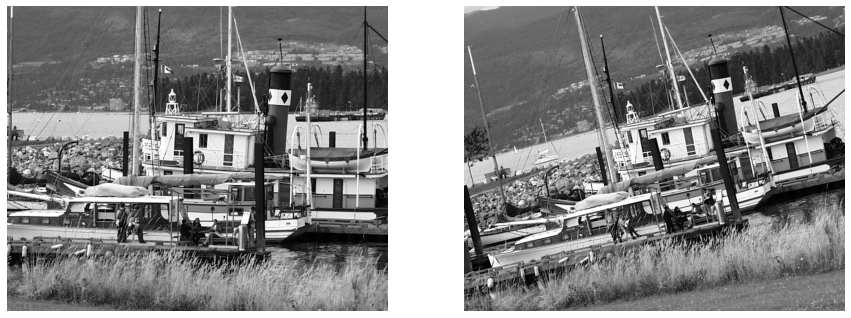

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter

im1 = cv2.imread('boat.tar/img1.pgm', 0)
im2 = cv2.imread('boat.tar/img2.pgm', 0)
f, axs = plt.subplots(1,2,figsize=(15, 15))
axs[0].imshow(im1, cmap='gray')
axs[0].axis('off')

axs[1].imshow(im2, cmap='gray')
axs[1].axis('off')

Because the SIFT and SURF is unavailable in colab, the ORB feature descriptor is used. At first, the key points and corresponding feature vectors are detected.

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


(-0.5, 849.5, 679.5, -0.5)

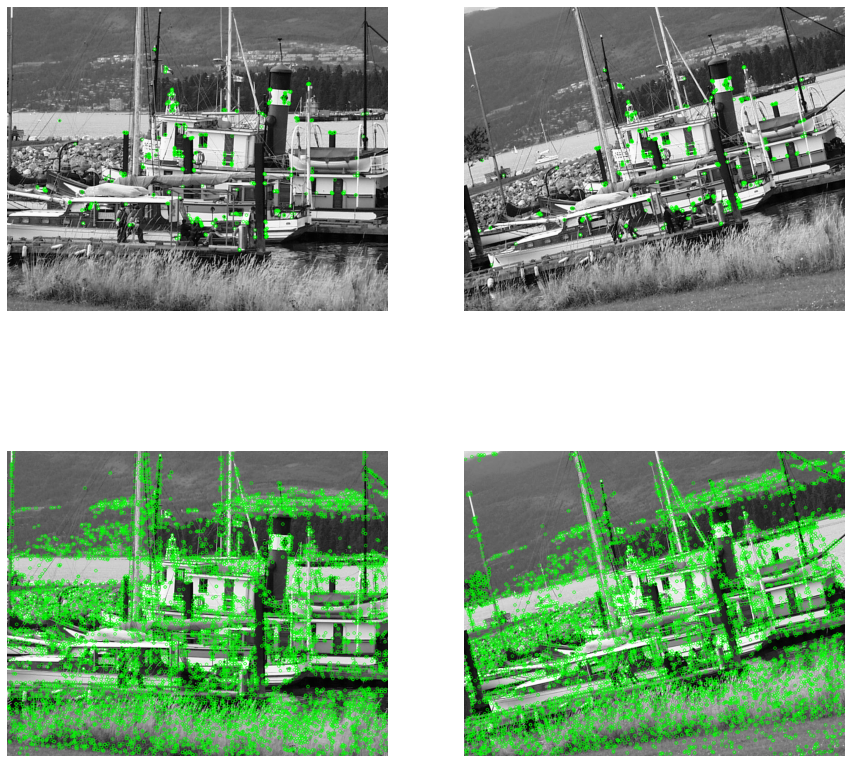

In [48]:
# Initiate ORB detector

orb = cv2.ORB_create()
orb_sift = cv2.SIFT_create()

# detect the key points and corresponding feature descriptor
#kp is key point and des is descriptor
kp_1, des_1 = orb.detectAndCompute(im1, None)
kp_2, des_2 = orb.detectAndCompute(im2, None)

kp_3, des_3 = orb_sift.detectAndCompute(im1, None)
kp_4, des_4 = orb_sift.detectAndCompute(im2, None)
# draw the key points
im1_keypoints = cv2.drawKeypoints(im1, kp_1, None, [0, 255, 0], flags=0)
im2_keypoints = cv2.drawKeypoints(im2, kp_2, None, [0, 255, 0], flags=0)
im3_keypoints = cv2.drawKeypoints(im1, kp_3, None, [0, 255, 0], flags=0)
im4_keypoints = cv2.drawKeypoints(im2, kp_4, None, [0, 255, 0], flags=0)


f, axs = plt.subplots(2,2,figsize=(15,15))
print(axs)
axs[0][0].imshow(im1_keypoints)
axs[0][0].axis('off')

axs[0][1].imshow(im2_keypoints)
axs[0][1].axis('off')

axs[1][0].imshow(im3_keypoints)
axs[1][0].axis('off')

axs[1][1].imshow(im4_keypoints)
axs[1][1].axis('off')




[[ 98 160 241 ...  12  86 143]
 [210  36 190 ... 112 167  34]
 [195  56 158 ... 113  43 138]
 ...
 [213 244  61 ...  59  85  37]
 [240 204  67 ... 187 114  60]
 [121 255  88 ... 130 202 139]]
[[159 138 134 ... 164  49 152]
 [228 123 249 ...  59 214 241]
 [ 86  46 216 ... 107  95 134]
 ...
 [ 34  52  97 ...  13  70 183]
 [247  71  12 ... 251 184  80]
 [194 186 158 ...  12 133  95]]
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   3.  21. ...   3.   1.   1.]
 [  3.   8.  81. ...  12.  10.  45.]
 ...
 [ 66.  76.  49. ...   0.   0.   0.]
 [100.   8.   1. ...   5.  39. 107.]
 [  0.   1.  26. ...  19.   1.   2.]]
[[  4.  12.  13. ...   0.   3.   2.]
 [  0.   0.   1. ...   0.   0.   0.]
 [103.  22.   1. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   3.]
 [ 30.  76.  37. ...   0.   0.   0.]
 [ 17.   5.   0. ...  28.  43.  26.]]
<DMatch 000001A9E1E74CD0>


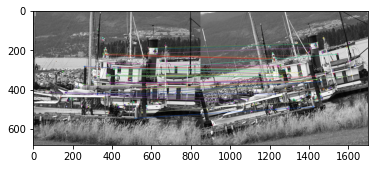

(<matplotlib.image.AxesImage at 0x1a9f70ee130>, None)

In [62]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_1, des_2) 
print(des_1)
print(des_2)
print(des_3)
print(des_4)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
print(matches[0])
# Draw all matches.

img3 = cv2.drawMatches(im1, kp_1, im2, kp_2, matches[:50], None)

plt.imshow(img3),plt.show()

# Example of sorted() and itemgitter

In [65]:
a = np.array([4,5,3,2,1])
b_0 = sorted(enumerate(a))
b_1 = sorted(enumerate(a), key=itemgetter(1))
print(b_0)
print(b_1)


[(0, 4), (1, 5), (2, 3), (3, 2), (4, 1)]
[(4, 1), (3, 2), (2, 3), (0, 4), (1, 5)]


# Q4. Sorting out good matching pairs

In [70]:
def ambiguous_detection(des_1, des_2):
    num_points = des_1.shape[0]
    distance_map = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distance_map[i,j] = np.sqrt(np.sum((des_1[i,:] - des_2[j,:])**2))

    accept_list = []
    match_list = []
    for n in range(num_points):
        distance_n = sorted(enumerate(distance_map[n, :]), key=itemgetter(1))
        match_idx, distance_1st = distance_n[0]
        _, distance_2rd = distance_n[1]
        ratio = distance_1st / distance_2rd
        if ratio < 0.75:
            accept_list.append(n)
            match_list.append(match_idx)
    
    print('The accepted key points:', accept_list)
    print('Matching indexes:', match_list)

    return accept_list, match_list



In [71]:
accept_list, match_list = ambiguous_detection(des_1=des_1, des_2=des_2)

The accepted key points: [12, 18, 38, 40, 45, 50, 54, 65, 69, 70, 79, 86, 88, 102, 105, 113, 116, 127, 129, 131, 133, 140, 141, 144, 145, 146, 148, 149, 151, 153, 156, 158, 164, 167, 180, 182, 184, 185, 187, 194, 197, 199, 205, 208, 212, 213, 214, 216, 218, 219, 220, 223, 227, 228, 229, 236, 242, 246, 253, 255, 257, 274, 275, 276, 277, 279, 281, 283, 288, 289, 290, 295, 296, 300, 306, 308, 309, 320, 328, 331, 332, 336, 338, 339, 342, 343, 345, 354, 355, 356, 361, 363, 364, 367, 369, 371, 377, 381, 384, 390, 392, 395, 396, 399, 404, 414, 416, 419, 431, 433, 436, 439, 444, 445, 446, 447, 451, 454, 456, 458, 460, 463, 469, 470, 472, 476, 477, 478, 480, 481, 482, 484, 485, 487, 496]
Matching indexes: [13, 30, 12, 47, 128, 107, 28, 56, 81, 34, 99, 76, 67, 90, 57, 9, 159, 128, 73, 46, 51, 19, 1, 12, 15, 10, 107, 41, 68, 99, 84, 83, 23, 93, 13, 40, 129, 24, 36, 31, 76, 141, 114, 197, 121, 25, 140, 157, 179, 165, 150, 112, 152, 182, 170, 107, 138, 145, 122, 191, 227, 207, 310, 214, 249, 239, 2

In [72]:
good_match_kp1_coord = np.zeros((len(accept_list), 2), dtype=np.float32)
good_match_kp2_coord = np.zeros((len(accept_list), 2), dtype=np.float32)

In [73]:
for i, idx in enumerate(accept_list):
    good_match_kp1_coord[i, 0] = kp_1[idx].pt[0]
    good_match_kp1_coord[i, 1] = kp_1[idx].pt[1]
    good_match_kp2_coord[i, 0] = kp_2[match_list[i]].pt[0]
    good_match_kp2_coord[i, 1] = kp_2[match_list[i]].pt[1]

In [74]:
Homography, _ =  cv2.findHomography(good_match_kp1_coord, good_match_kp2_coord, cv2.RANSAC)

In [75]:
print(Homography)

[[ 8.65811091e-01  2.12938892e-01  8.68309151e+00]
 [-2.11603757e-01  8.60185888e-01  1.30935651e+02]
 [ 8.42859543e-06  2.02304068e-07  1.00000000e+00]]


In [76]:
GT = np.array([[8.5828552e-01, 2.1564369e-01, 9.9101418e+00],
               [-2.1158440e-01, 8.5876360e-01, 1.3047838e+02],
               [2.0702435e-06, 1.2886110e-06, 1.0000000e+00]])

print(GT)

[[ 8.5828552e-01  2.1564369e-01  9.9101418e+00]
 [-2.1158440e-01  8.5876360e-01  1.3047838e+02]
 [ 2.0702435e-06  1.2886110e-06  1.0000000e+00]]
